In [1]:
from loadphantom import BreastPhantomReader
file_path = "../../data/breast/"
reader = BreastPhantomReader(file_path)

Phantom ID 012304 loaded successfully.
Dimensions (s1, s2, s3): (215, 328, 212)
Classification: 4


In [8]:
freq = 1. # GHz
epsilon_rb = 1.
sigma_b = 0.

reader.set_immersion_medium_properties(dielectric_constant=epsilon_rb,
                                       conductivity=sigma_b)

epsilon_r, sigma = reader.calculate_dielectric_properties(
    freq, model='debye'
)

Immersion medium properties set: εr=1.0, σ=0.0 S/m


In [9]:
import numpy as np
# Find locations where relative permittivity equals zero
zero_locations = (epsilon_r == 0)
print(f"Found {zero_locations.sum()} locations with epsilon_r = 0")

# Get the material type at those locations
if zero_locations.any():
    # Find the first occurrence of zero permittivity
    zero_indices = np.where(zero_locations)
    first_zero_idx = (zero_indices[0][0], zero_indices[1][0], zero_indices[2][0])
    
    # Check the material type at that location
    material_type = reader.mtype_grid[first_zero_idx]
    print(f"Material type at zero permittivity location {first_zero_idx}: {material_type}")
    
    # Check what this material type represents
    print(f"Material type value: {material_type}")
else:
    print("No locations with epsilon_r = 0 found")

Found 0 locations with epsilon_r = 0
No locations with epsilon_r = 0 found


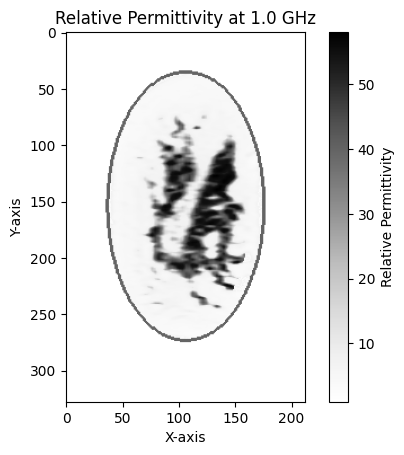

In [10]:
from matplotlib import pyplot as plt
plt.imshow(epsilon_r[140, :, :], cmap='Greys')
plt.colorbar(label='Relative Permittivity')
plt.title(f'Relative Permittivity at {freq} GHz')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

Degrees of freedom: 17


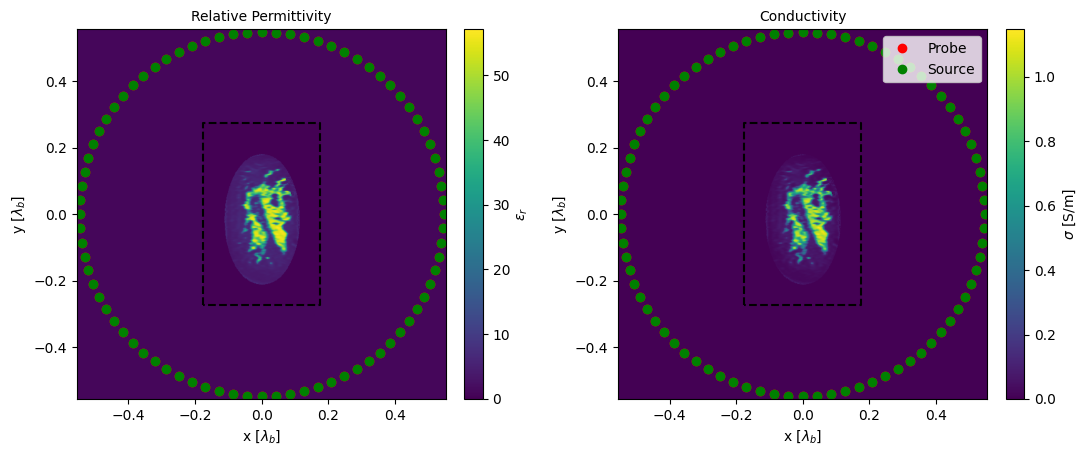

In [4]:
import numpy as np
import sys
sys.path.insert(1, '../../eispy2d/library/')
import configuration as cfg

epsr = np.squeeze(epsilon_r[140, :, :])
sig = np.squeeze(sigma[140, :, :])

instance_name = 'breastphantom'
dx = dy = 0.5e-3 # 0.5 mm
Lx, Ly = epsr.shape[1] * dx, epsr.shape[0] * dy
max_epsilon_r = epsr.max()
object_radius = min([Lx, Ly]) / 2.0
DOF = cfg.degrees_of_freedom(object_radius, frequency=freq*1e9,
                             epsilon_r=max_epsilon_r)
print(f"Degrees of freedom: {DOF}")
NS = NM = 80
Ro = max([Lx, Ly])
epsilon_rb = 1.
sigma_b = 0.
image_size = [Ly, Lx]
E0 = 1.

config = cfg.Configuration(name=instance_name + '.cfg',
                           number_measurements=NM,
                           number_sources=NS,
                           observation_radius=Ro,
                           frequency=freq*1e9,
                           background_permittivity=epsilon_rb,
                           background_conductivity=sigma_b,
                           image_size=image_size,
                           wavelength_unit=False,
                           magnitude=E0)

config.draw(epsr=epsr, sig=sig, show=True)

In [5]:
# import inputdata as ipt
# import result as rst

# test = ipt.InputData(name=instance_name + '.ipt',
#                      configuration=config,
#                      rel_permittivity=epsr,
#                      conductivity=sig,
#                      indicators=[rst.SHAPE_ERROR, rst.POSITION_ERROR,
#                                  rst.OBJECTIVE_FUNCTION])
# test.compute_dnl()
# print(test)

In [6]:
# import mom_cg_fft as mom
# forward = mom.MoM_CG_FFT(tolerance=1e-3, maximum_iterations=5_000)
# _ = forward.solve(test)

In [8]:
import inputdata as ipt
import richmond as ric
resolution = (40, 40)
test = ipt.InputData(import_filename=instance_name + '.ipt',
                     import_filepath='../../data/breast/')
discretization = ric.Richmond(configuration=test.configuration,
                              elements=resolution)
print(test)

Input name: breastphantom.ipt
Configuration file: breastphantom.cfg
Images Resolution: 328x212
Scattered field - measurement samples: 80
Scattered field - source samples: 80
Total field - measurement samples: 69536
Total field - source samples: 80
Relative Permit. map shape: 328x212
Conductivity map shape: 328x212
Indicators: ['zeta_s', 'zeta_p', 'objective_function']
Degrees of Non-Linearity: 0.8122


Method: Subspace-based Optimization Method
Alias: som
Input Data: breastphantom.ipt
Discretization: Richmond Method (40x40)
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Stop Criteria
Maximum number of iterations: 30
Iteration: 1 -  Shape: inf, Position: 5.61, Ob. Func.: 1.103e+01,
Iteration: 2 -  Shape: inf, Position: 5.64, Ob. Func.: 1.023e+01,
Iteration: 3 -  Shape: inf, Position: 5.14, Ob. Func.: 9.800e+00,
Iteration: 4 -  Shape: inf, Position: 4.91, Ob. Func.: 9.585e+00,
Iteration: 5 -  Shape: inf, Position: 4.82, Ob. Func.: 9.416e+00,
Iteration: 6 -  Shape: inf, Position: 4.96, Ob. Func.: 9.273e+00,
Iteration: 7 -  Shape: inf, Position: 5.97, Ob. Func.: 9.147e+00,
Iteration: 8 -  Shape: inf, Position: 6.76, Ob. Func.: 9.035e+00,
Iteration: 9 -  Shape: inf, Position: 7.04, Ob. Func.: 8.934e+00,
Iteration: 10 -  Shape: inf, Position: 7.42, Ob. Func.: 8.842e+00,
Iteration: 20 -  Shape: inf, Position: 8.40, Ob. Func.: 8.224e+00,
Iteration: 30 -  Shape: inf, Position

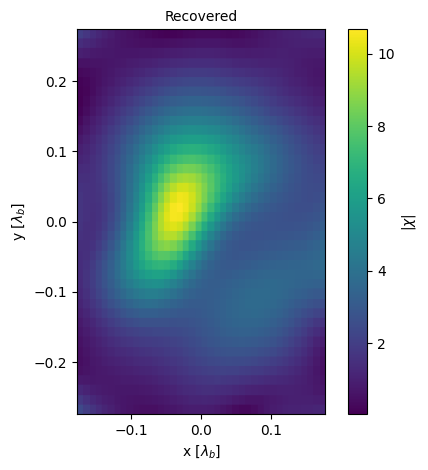

In [10]:
import som
import stopcriteria as stp

method = som.SubspaceBasedOptimizationMethod(
    stp.StopCriteria(max_iterations=30), cutoff_index=15
)

result = method.solve(test, discretization)

result.plot_map(show=True)